In [44]:
import pandas as pd
import numpy as np
import json
import re

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg

from gensim.models import word2vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pprint import pprint

from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt

from datetime import date

from process_df_functions import unravel_lists

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Initialize utility files

In [45]:
with open('./rsc/fxn_grps.json', 'r') as fp:
    fxn_grp_dict = json.load(fp)
    
with open('./rsc/df_columns.json', 'r') as fp:
    column_filters = json.load(fp)
    
with open('./rsc/chems_dict.json', 'r') as fp:
    chems_dict = json.load(fp)
    
compounds = list(fxn_grp_dict.keys())

### import data files and create master dataframes

Separating into syntheses from literature and those performed in-house. Take note of the dates considered and saved!

In [46]:
# data = './data/bfo_df_20230211.csv'
data = './data/bfo_df_20230525_no_amorphous.csv'
pred_data = './data/20230519_bfo_test_for_prediction.csv'
prep_date = date.today().strftime('%Y%m%d')

In [47]:
raw_df = pd.read_csv(data)
raw_df = raw_df.dropna(thresh=1)

raw_lit_df = raw_df[~raw_df['doi'].isin(['Sutter-Fella Lab', 'Sutter-Fella Lab -- suggested', 'Sutter-Fella Lab -- replication'])]
raw_inhouse_df = raw_df[raw_df['doi'].isin(['Sutter-Fella Lab', 'Sutter-Fella Lab -- suggested', 'Sutter-Fella Lab -- replication'])]

print('Number of recipes from literature: ', len(raw_lit_df))
print('Number of papers: ', raw_lit_df['doi'].nunique())

print()

print('Number of in-house recipes (unprompted): ', len(raw_inhouse_df[raw_inhouse_df['doi']=='Sutter-Fella Lab']))
print('Number of in-house recipes (suggested): ', len(raw_inhouse_df[raw_inhouse_df['doi']=='Sutter-Fella Lab -- suggested']))

df = raw_df.loc[:, column_filters['master']]

lit_df = raw_lit_df.loc[:, column_filters['master']]
inhouse_df = raw_inhouse_df.loc[:, column_filters['master']]

df.to_csv(f'./data/bfo_df_master_{prep_date}.csv')
lit_df.to_csv(f'./data/bfo_lit_df_master_{prep_date}.csv')
inhouse_df.to_csv(f'./data/bfo_inhouse_df_master_{prep_date}.csv')

Number of recipes from literature:  331
Number of papers:  177

Number of in-house recipes (unprompted):  17
Number of in-house recipes (suggested):  15


# Alternative: DF for prediction

If you want to build df for prediction, switch cell below to True

In [48]:
for_prediction = True

In [49]:
# Define dataframe to test predictions
if for_prediction:
    raw_pred_df = pd.read_csv('./data/20230519_bfo_test_for_prediction.csv')
    raw_pred_df = raw_pred_df.dropna(thresh=1)

    pred_df = raw_pred_df.loc[:, column_filters['master']]

    pred_df.to_csv(f'./data/bfo_test_for_prediction_df_master_{prep_date}.csv')

### Unravel specific impurity phases from `reported_impurities`

Each specific impurity needs to be converted into a column where values are one-hot encoded

In [50]:
impurities = list(df['reported_impurities'])

# need to call unravel_lists twice right now (can be better constructed)
#    First to obtain the column names from unraveled lists
#    Second to obtain the one hot-encoded dataframe

impurities_list = unravel_lists(series_list=impurities, throwaway=['[]', np.nan, 'amorphous'])
print(impurities_list)
impurities_array = unravel_lists(series_list=impurities, throwaway=['[]', np.nan, 'amorphous'], reappropriate=True, one_hot_columns=impurities_list)

df[impurities_list] = impurities_array

['Bi2Fe4O9', 'Bi25FeO40', 'Bi46Fe2O72', 'Fe2O3', 'Bi36Fe24O57', 'Bi2O2.3', 'Bi-rich', 'Bi25FeO39', 'Bi2Fe4O7', 'unspecified', 'Bi2O2.33', 'Bi36Fe2O57', 'Bi24Fe2O39', 'FeOOH', 'Fe0.942O', 'Bi2O3', 'unknown']


### Convert specific impurity phases to binary indicator

Column indicates 1 if an impurity phase formed and 0 if synthesis was phase pure

In [51]:
#codify impurity presence
impurity_codes = df[impurities_list].sum(axis=1).astype(bool).astype(int)
df['impurity_code'] = impurity_codes

### Convert specific impurity phases to multiclass indicators

Column indicates 0 if no impurity phase forms, 1 if an iron-rich impurity phase forms, 2 if a bismuth-rich impurity phase forms, or 3 if both iron-rich and bismuth-rich impurity phases form

OR

Columns use one-hot encoding to indicate whether that kind of impurity phase forms, so just two columns: one for iron-rich and one for bi-rich

In [52]:
#codify multiclass impurity presence
display(df)

#WARNING these are commented out for the prediction dataset, uncomment if you are retraining from full set (need to make this more flexible)

if not for_prediction:
    fe_rich = [
        'Bi2Fe4O9',
        'Fe2O3',
        'Fe0.942O',
        'Bi2Fe4O7',
        'FeOOH'
    ]
    bi_rich = [
        'Bi-rich',
        'Bi46Fe2O72',
        'Bi24Fe2O39',
        'Bi2O3',
        'Bi36Fe2O57',
        'Bi36Fe24O57',
        'Bi25FeO40',
        'Bi2O2.33',
        'Bi2O2.3',
        'Bi25FeO39'
    ]
else:
    fe_rich = []
    bi_rich = []
    
fe_rich_indicator = df[fe_rich].sum(axis=1).astype(bool).astype(int)
bi_rich_indicator = df[bi_rich].sum(axis=1).astype(bool).astype(int)

df['fe_rich_indicator'] = fe_rich_indicator
df['bi_rich_indicator'] = bi_rich_indicator

,recipe_id,url,doi,source_Bi,source_Bi_amount,source_Fe,source_Fe_amount,bi_fe_ratio,separate_hydrolysis,solvent1,solvent1_amount_ml,solvent2,solvent2_amount_ml,solv1_solv2_ratio,chelating_agent1,chelating_agent1_amount_ml,chelating_agent2,chelating_agent2_amount_ml,chelating_agent3,chelating_agent3_amount_ml,solv_chel_ratio,dehydrating_agent1,dehydrating_agent1_amount_ml,dehydrating_agent2,dehydrating_agent2_amount,solv_dehydr_ratio,surfactant,surfactant_amount,solv_surfactant_ratio,precursor_concentration,pH,substrate,subtrate_orientation,stirring_time_hr,stirring_temp_degC,age_days,age_temp_degC,low_coating_time_sec,low_coating_rpm,high_coating_time_sec,high_coating_rpm,dry_time_min,dry_degC,layer_prebake_time_min,layer_prebake_degC,layer_annealing_time_min,layer_annealing_degC,layers,final_prebake_time_min,final_prebake_degC,final_annealing_time_hr,final_annealing_degC,atmosphere,reported_impurities,space_group,main_XRD_peaks,thin_film_thickness_nm,validation_KC,validation_VB,Validation_Notes,Extraction_Notes,Bi2Fe4O9,Bi25FeO40,Bi46Fe2O72,Fe2O3,Bi36Fe24O57,Bi2O2.3,Bi-rich,Bi25FeO39,Bi2Fe4O7,unspecified,Bi2O2.33,Bi36Fe2O57,Bi24Fe2O39,FeOOH,Fe0.942O,Bi2O3,unknown,impurity_code
0,1.0,https://link.springer.com/content/pdf/10.1007/...,10.1007/s00339-016-9628-3,bi_nitrate_pentahydrate,NaN,fe_nitrate_nonahydrate,NaN,1.100,NaN,2_methoxyethanol,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200,NaN,Pt/Ti/SiO2/Si,Si(100),3,50.0,2.00000,25.0,15.0,400.0,30.0,4000.0,NaN,NaN,5.0,280.0,5.000000,550.0,12,NaN,NaN,0.333333,550.0,O2,[],R3c,"(012), (104), (110)",NaN,NaN,completed,"RTA for intermediate annealing, assumed atmosp...","coating, prebake (280 5min), anneal (550 5min)...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2.0,https://link.springer.com/article/10.1007/s108...,10.1007/s10853-014-8318-9,bi_nitrate_pentahydrate,NaN,fe_nitrate_nonahydrate,NaN,1.050,NaN,2_methoxyethanol,NaN,NaN,NaN,NaN,acetic_acid,NaN,NaN,NaN,NaN,NaN,NaN,acetic_acid_glacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200,NaN,glass/ITO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,550.0,N2,[],R3c,"(102), (104), (110)",350.0,NaN,completed,NaN,Mn doping; solution prep described in 10.1063/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,4.0,NaN,10.1007/s10854-013-1374-0,bi_nitrate_pentahydrate,NaN,fe_nitrate_nonahydrate,NaN,1.100,NaN,2_methoxyethanol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ethanolamine,NaN,NaN,NaN,NaN,glass,NaN,1,25.0,NaN,NaN,NaN,NaN,30.0,3000.0,NaN,NaN,5.0,350.0,NaN,NaN,5,NaN,NaN,1.000000,600.0,air,['Bi2Fe4O9'],R3c,"(012), (104), (110)",NaN,NaN,completed,NaN,coating and pre-fire repeated 5 times; used to...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,5.0,NaN,10.1007/s10854-013-1374-0,bi_nitrate_pentahydrate,NaN,fe_nitrate_nonahydrate,NaN,1.100,NaN,2_methoxyethanol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ethanolamine,NaN,NaN,NaN,NaN,glass,NaN,1,25.0,NaN,NaN,NaN,NaN,30.0,3000.0,NaN,NaN,5.0,350.0,NaN,NaN,5,NaN,NaN,3.000000,500.0,air,['Bi2Fe4O9'],R3c,"(012), (104), (110)",NaN,NaN,completed,NaN,coating and pre-fire repeated 5 times; impurit...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,6.0,NaN,10.1007/s10854-013-1374-0,bi_nitrate_pentahydrate,NaN,fe_nitrate_nonahydrate,NaN,1.100,NaN,2_methoxyethanol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ethanolamine,NaN,NaN,NaN,NaN,glass,NaN,1,25.0,NaN,NaN,NaN,NaN,30.0,3000.0,NaN,NaN,5.0,350.0,NaN,NaN,5,NaN,NaN,6.000000,500.0,air,['Bi2Fe4O9'],R3c,"(012), (104), (110)",NaN,NaN,completed,NaN,coating and pre-fire repeated 5 times; impurit...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,7.0,NaN,10.1007/s10854-013-1374-0,bi_nitrate_pentahydrate,NaN,fe_nitrate_nonahydrate,NaN,1.100,NaN,2_methoxyethanol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Codify type of Bi and Fe precursors

* If both Bi and Fe nitrate precursors are used, then value is 1
* If one of Bi and Fe nitrate precursor is used and other is not nitrate, value is 0
    * note that Bi is always nitrate if one of the two is nitrate
* If neither Bi nor Fe nitrate precursor is used, then value is -1

In [53]:
#codify Bi/Fe precursor
nitrate_precs = []
for i, (bi, fe) in enumerate(
    zip(df['source_Bi'].to_list(), 
        df['source_Fe'].to_list())
):
    if bi == 'bi_nitrate_pentahydrate' and fe == 'fe_nitrate_nonahydrate':
        nitrate_precs.append(1)
    elif bi == 'bi_nitrate_pentahydrate' or fe == 'fe_nitrate_nonahydrate':
        nitrate_precs.append(0) #Fe is always the other, never Bi
    else:
        nitrate_precs.append(-1)
        
df['nitrate_precs'] = nitrate_precs

### Convert `separate_hydrolysis` from boolean to 0-1 indicator

In [54]:
df['separate_hydrolysis'].fillna(False, inplace=True)
df['separate_hydrolysis'] = df['separate_hydrolysis'].astype(int)

### Treat glacial acetic acid and acetic anhydride as the same chemical

Probably shouldn't do this... but can comment out if needed

In [55]:
df.replace({'acetic_acid_glacial' : 'acetic_anhydride'}, inplace=True)
#display(df)

### One-hot encode all chemicals included in pot

* solvents
* chelating agents
* dehydrating agents

In [56]:
# Define one-hot encoder

ohe = OneHotEncoder(handle_unknown='ignore')
def get_ohes(df, column):
    ohe.fit(df[[column]])
    return pd.DataFrame(
        ohe.transform(df[[column]]).todense(),
        columns=ohe.get_feature_names([column]),
        index=df.index
    )

In [57]:
# Define solvents, dehydrating agents, and chelating agents of interest

solvents = [
    '2_methoxyethanol',
    'ethylene_glycol'
]

dehydrating_agents = [
    'acetic_acid_glacial',
    'acetic_anhydride',
    'acetylacetone'
]

chelating_agents = [
    'acetic_acid',
    'citric_acid'
]

other = [
    'trimethylene_glycol',
    'ethanol',
    'ethanolamine',
    'diethanolamine',
    'nitric_acid', 
    'ethylenediamine', 
    'ammonium_hydroxide', 
    'acetone',
    'polyvinylpyrrolidone', 
    'nn_dimethylformamide',
]

# Establish one-hot encodings for each chemical category

ohe_dfs = {
    'ohe_solvent1' : get_ohes(df, 'solvent1'),
    'ohe_solvent2' : get_ohes(df, 'solvent2'),
    'ohe_chelating_agent1' : get_ohes(df, 'chelating_agent1'),
    'ohe_chelating_agent2' : get_ohes(df, 'chelating_agent2'),
    'ohe_chelating_agent3' : get_ohes(df, 'chelating_agent3'),
    'ohe_dehydrating_agent1' : get_ohes(df, 'dehydrating_agent1'),
    'ohe_dehydrating_agent2' : get_ohes(df, 'dehydrating_agent2'),
    'ohe_surfactant' : get_ohes(df, 'surfactant') 
}
    
# Remove columns ending in "_nan"
    
for frame in ohe_dfs.keys():
    ohe_dfs[frame] = ohe_dfs[frame][ohe_dfs[frame].columns.drop(list(ohe_dfs[frame].filter(regex='_nan')))]

# Concatenate one-hot encodings to master dataframe
#     Note that this should only be run once since cell will keep concatenating one-hot encoded columns

for frame in ohe_dfs.keys():
    df = pd.concat((df, ohe_dfs[frame]), axis=1)
    
# Extract the chemicals of interest
#     Note that dehydrating agents coming before chelating agents and the order of items in the lists matters
#     at the moment since "acetic_acid" will pick up "acetic_acid_glacial". 
    
for solv in solvents:
    solv_columns = [col for col in df.columns if bool(re.match(".*_{}$".format(solv), col))]
    df[solv] = df[solv_columns].sum(axis=1)  
    df[solv].clip(upper=1.0, inplace=True)
    df = df.drop(solv_columns, axis=1)
    
for dehy in dehydrating_agents:
    dehy_columns = [col for col in df.columns if bool(re.match(".*_{}$".format(dehy), col))]
    df[dehy] = df[dehy_columns].sum(axis=1)  
    df[dehy].clip(upper=1.0, inplace=True)
    df = df.drop(dehy_columns, axis=1)
    
for chel in chelating_agents:
    chel_columns = [col for col in df.columns if bool(re.match(".*_{}$".format(chel), col))]
    df[chel] = df[chel_columns].sum(axis=1)  
    df[chel].clip(upper=1.0, inplace=True)
    df = df.drop(chel_columns, axis=1)
    
for oth in other:
    oth_columns = [col for col in df.columns if bool(re.match(".*_{}$".format(oth), col))]
    df[oth] = df[oth_columns].sum(axis=1)
    df[oth].clip(upper=1.0, inplace=True)
    df = df.drop(oth_columns, axis=1)

#display(df)

/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/skle

### Create PCA coordinates for chemicals

In [58]:
def get_values(identifier, projections, n_dim=2, c_str="chem_PCA-t-SNE-c"):
    if c_str == 'chem_PCA-t-SNE-c':
        assert n_dim < 4
    values = np.array(())
    for i in range(n_dim):
        values = np.append(values, projections[c_str + str((i+1))][str(identifier)])
    return values

In [59]:
model = word2vec.Word2Vec.load('/Users/kevcruse96/Documents/GitHub/mol2vec/examples/models/model_300dim.pkl')

mols = [Chem.MolFromSmiles(chems_dict[chem]['SMILES']) for chem in chems_dict.keys()]

mol_sentences = [mol2alt_sentence(mol, 1) for mol in mols]
flat_list = [item for sublist in mol_sentences for item in sublist]
mol_identifiers_unique = set(flat_list)

df_vec = pd.DataFrame()
df_vec['identifier'] = list(mol_identifiers_unique)
df_vec.index = df_vec['identifier']

In [60]:
pca_model = PCA(n_components=len(df_vec))
pca_result = pca_model.fit_transform([model.wv.word_vec(x) for x in mol_identifiers_unique])
tsne_model = TSNE(n_components=3, perplexity=10, n_iter=1000, metric='cosine')
tsne_pca = tsne_model.fit_transform(pca_result)

chem_pca_columns = ["chem_pca-c{}".format(i+1) for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, index=list(mol_identifiers_unique), columns=chem_pca_columns)

df_vec['chem_PCA-t-SNE-c1'] = tsne_pca.T[0]
df_vec['chem_PCA-t-SNE-c2'] = tsne_pca.T[1]
df_vec['chem_PCA-t-SNE-c3'] = tsne_pca.T[2]

df_vec = df_vec.join(pca_df)
projections = df_vec.to_dict()

/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [61]:
n_dim = 30

for mol, name in zip(mols, list(chems_dict.keys())):
    pca_subs = [get_values(x, projections, n_dim=n_dim, c_str="chem_pca-c") for x in mol2alt_sentence(mol, 1)]
    summed_vec = np.array(list(sum(pca_subs)))
    chems_dict[name]['vector'] = summed_vec

Get list of constituent chemicals from each row

In [62]:
constituent_chemicals = df[list(chems_dict.keys())].apply(lambda row: row[row == 1.0].index, axis=1)

pcas = np.zeros((len(df), n_dim))

for i, rec in enumerate(constituent_chemicals):
    vectors = []
    names = rec.values
    for name in names:
        vectors.append(chems_dict[name]['vector'])
    pcas[i] = sum(vectors)

df[chem_pca_columns[:n_dim]] = pcas

### One-hot encode different annealing atmospheres

In [63]:
#codify atmosphere
air_atm = []
o2_atm = []
n2_atm = []
for atm in df['atmosphere'].tolist():
    if atm == 'O2':
        air_atm.append(0)
        o2_atm.append(1)
        n2_atm.append(0)
    elif atm == 'N2':
        air_atm.append(0)
        o2_atm.append(0)
        n2_atm.append(1)
    else:
        air_atm.append(1)
        o2_atm.append(0)
        n2_atm.append(0)
        
df['air_atm'] = air_atm
df['o2_atm'] = o2_atm
df['n2_atm'] = n2_atm

## Update qualitative values

* For now, need to simply make these NaN
* later, update them for modeling with median values

In [64]:
df['stirring_time_hr'].replace({
    "several hours" : np.nan
}, inplace=True)

df['layers'].replace({
    "several" : np.nan,
    "couple" : 2
}, inplace=True)

In [65]:
cols2del = [
    "solvent1_amount_ml",
    "solv1_solv2_ratio",
    "chelating_agent1_amount_ml",
    "chelating_agent2_amount_ml",
    "chelating_agent3_amount_ml",
    "solv_chel_ratio",
    "dehydrating_agent1_amount",
    "dehydrating_agent2_amount",
    "solv_dehydr_ratio",
    "surfactant_amount",
    "solv_surfactant_ratio",
    "solvent1_2_ethoxyethanol",
    "solvent1_ethanol",
    "solvent1_nn_dimethylformamide",
    "solvent1_propylene_glycol",
    "solvent1_trimethylene_glycol",
    "solvent1_water",
    "solvent2_ethanol",
    "solvent2_formamide",
    "solvent2_nitric_acid",
    "solvent2_polyethylene_glycol",
    "solvent2_propionic_acid",
    "chelating_agent1_ethanolamine",
    "chelating_agent1_nitric_acid",
    "chelating_agent2_diethanolamine",
    "chelating_agent2_nitric_acid",
    "chelating_agent3_ammonium_hydroxide",
    "dehydrating_agent1_acetone",
    "dehydrating_agent1_formamide",
    "dehydrating_agent1_nn_dimethylformamide",
    "dehydrating_agent2_nn_dimethylformamide",
    "surfactant_PEO-PPO-PEO",
    # delete below because we have mol2vec embeddings now
    "2_methoxyethanol",
    "ethylene_glycol",
    "acetic_acid_glacial",
    "acetic_anhydride",
    "acetylacetone",
    "acetic_acid",
    "citric_acid",
]

cols2del.extend([col for col in chem_pca_columns[n_dim:]])

for col in cols2del:
    del column_filters['modeling'][column_filters['modeling'].index(col)]

lit_df = df[~df['doi'].isin(['Sutter-Fella Lab', 'Sutter-Fella Lab -- suggested'])]
lit_df_viz = lit_df.loc[:, column_filters['modeling']]
lit_df_viz.to_csv(f'./data/bfo_lit_df_viz_{prep_date}.csv')

## Update appropriate NaN values to 0

Only updating for columns which we can assume were simply not incorporated into the experiment (like aging, drying, etc.)

In [66]:
def nan2zero(df, col_regex, remove_ids=[]):
    cols = [col for col in df.columns if bool(re.match(col_regex, col))]
    if remove_ids:
        for rem in remove_ids:
            del cols[rem]
    df[cols] = df[cols].fillna(0)
    return df

### Update values in ratio columns

* If NaN but two amounts are available calculate the ratio __[TODO]__
* else, update NaN to 0

In [67]:
df = nan2zero(df, ".*_ratio$", remove_ids=[0])

### Update NaN age values to 0

In [68]:
df = nan2zero(df, "^age_")

### Update NaN low_coating values to 0

In [69]:
df = nan2zero(df, "^low_coating_.*")

### Update NaN dry values to 0

In [70]:
df = nan2zero(df, "^dry_")

### Update NaN prebake values to 0

In [71]:
df = nan2zero(df, ".*_prebake_.*")

### Update NaN layer anneal values to 0

In [72]:
df = nan2zero(df, "^layer_annealing_.*")

### Update NaN final anneal values to 0

In [73]:
df = nan2zero(df, "^final_annealing_.*")

### Save prepped dataframes to file

In [74]:
cols2del = [col for col in chem_pca_columns[n_dim:]]

for col in cols2del:
    del column_filters['eda'][column_filters['eda'].index(col)]

In [75]:
#display(df.loc[:, column_filters['eda']])

In [76]:
lit_df = df[~df['doi'].isin(['Sutter-Fella Lab', 'Sutter-Fella Lab -- suggested'])]
inhouse_df = df[df['doi'].isin(['Sutter-Fella Lab', 'Sutter-Fella Lab -- suggested'])]
only_suggested_df = df[df['doi'].isin(['Sutter-Fella Lab -- suggested'])]
suggested_df = df[~df['doi'].isin(['Sutter-Fella Lab'])]
explore_df = df[~df['doi'].isin(['Sutter-Fella Lab -- suggested'])]

df_eda = df.loc[:, column_filters['eda']]
lit_df_eda = lit_df.loc[:, column_filters['eda']]
inhouse_df_eda = inhouse_df.loc[:, column_filters['eda']]
only_suggested_df_eda = only_suggested_df.loc[:, column_filters['eda']]
suggested_df_eda = suggested_df.loc[:, column_filters['eda']]
explore_df_eda = explore_df.loc[:, column_filters['eda']]

df_eda.to_csv(f'./data/bfo_df_eda_{prep_date}.csv')
lit_df_eda.to_csv(f'./data/bfo_lit_df_eda_{prep_date}.csv')
inhouse_df_eda.to_csv(f'./data/bfo_inhouse_df_eda_{prep_date}.csv')
only_suggested_df_eda.to_csv(f'./data/bfo_only_suggested_df_eda_{prep_date}.csv')
suggested_df_eda.to_csv(f'./data/bfo_suggested_df_eda_{prep_date}.csv')
explore_df_eda.to_csv(f'./data/bfo_explore_df_eda_{prep_date}.csv')

### Below is for filling in blanks for layer and final prebake/annealing

This should be moved to data preprocessing for modeling, not to be used for EDA

In [77]:
#assume blank prebake times with no temp are zero
df['layer_prebake_time_min'] = df[['layer_prebake_time_min', 'layer_prebake_degC']].apply(
    lambda rec: 0 if rec['layer_prebake_degC']==0 else rec['layer_prebake_time_min'],
    axis=1
)

df['final_prebake_time_min'] = df[['final_prebake_time_min', 'final_prebake_degC']].apply(
    lambda rec: 0 if rec['final_prebake_degC']==0 else rec['final_prebake_time_min'],
    axis=1
)

df['final_prebake_time_min'] = df[['layer_prebake_time_min', 'final_prebake_time_min']].apply(
    lambda rec: rec['layer_prebake_time_min'] if rec['final_prebake_time_min']==0 else rec['final_prebake_time_min'],
    axis=1
)
df['final_prebake_degC'] = df[['layer_prebake_degC', 'final_prebake_degC']].apply(
    lambda rec: rec['layer_prebake_degC'] if rec['final_prebake_degC']==0 else rec['final_prebake_degC'],
    axis=1
)


df['final_prebake_time_min'] = df['final_prebake_time_min'].fillna(df['final_prebake_time_min'].median())

#display(df['final_prebake_degC'])

In [78]:
df['final_annealing_degC'] = df['final_annealing_degC'].fillna(0)

# df['final_annealing_degC'] = df[['layer_annealing_degC', 'final_annealing_degC']].apply(
#     lambda rec: rec['layer_annealing_degC'] if rec['final_annealing_degC'] == 0 else rec['final_annealing_degC'],
#     axis=1
# )
# df['final_annealing_degC'] = df['final_annealing_degC'].fillna(0)

df['layer_annealing_degC'] = df['layer_annealing_degC'].fillna(0)
df['layer_annealing_time_min'] = df['layer_annealing_time_min'].fillna(0)

#display(df['final_annealing_degC'])

In [79]:
df['final_annealing_time_hr'] = df['final_annealing_time_hr'].fillna(0)

# df['final_annealing_time_hr'] = df[['layer_annealing_time_min', 'final_annealing_time_hr']].apply(
#     lambda rec: rec['layer_annealing_time_min'] / 60 if rec['final_annealing_time_hr'] == 0 else rec['final_annealing_time_hr'],
#     axis=1
# )
df['final_annealing_time_hr'] = df['final_annealing_time_hr'].fillna(0)

#display(df['final_annealing_time_hr'])

### Fill in NaN values for specific columns with median value from literature

Note that median values are taken from `lit_df` (might want to change that?)

In [80]:
knn_df = df.copy()
mmvi_df = df.copy()

In [81]:
mmvi_df['stirring_time_hr'] = mmvi_df['stirring_time_hr'].fillna(lit_df['stirring_time_hr'].median())
mmvi_df['stirring_temp_degC'] = mmvi_df['stirring_temp_degC'].fillna(lit_df['stirring_temp_degC'].median())

mmvi_df['high_coating_time_sec'] = mmvi_df['high_coating_time_sec'].fillna(lit_df['high_coating_time_sec'].median())
mmvi_df['high_coating_rpm'] = mmvi_df['high_coating_rpm'].fillna(lit_df['high_coating_rpm'].median())

mmvi_df['pH'] = mmvi_df['pH'].fillna(lit_df['pH'].median())

mmvi_df['bi_fe_ratio'] = mmvi_df['bi_fe_ratio'].fillna(lit_df['bi_fe_ratio'].median())

mmvi_df['precursor_concentration'] = mmvi_df['precursor_concentration'].fillna(lit_df['precursor_concentration'].median())

mmvi_df['layers'] = mmvi_df['layers'].fillna(lit_df['layers'].median())

mmvi_df['thin_film_thickness_nm'] = mmvi_df['thin_film_thickness_nm'].fillna(lit_df['thin_film_thickness_nm'].median())

### Update values of amounts/ratios/etc.

__TODO__: fill this in

In [82]:
# For now, just ignore amount and ratio columns

cols2del = [
    "solvent1_amount_ml",
    "solv1_solv2_ratio",
    "chelating_agent1_amount_ml",
    "chelating_agent2_amount_ml",
    "chelating_agent3_amount_ml",
    "solv_chel_ratio",
    "dehydrating_agent1_amount",
    "dehydrating_agent2_amount",
    "solv_dehydr_ratio",
    "surfactant_amount",
    "solv_surfactant_ratio",
    "solvent1_2_ethoxyethanol",
    "solvent1_ethanol",
    "solvent1_nn_dimethylformamide",
    "solvent1_propylene_glycol",
    "solvent1_trimethylene_glycol",
    "solvent1_water",
    "solvent2_ethanol",
    "solvent2_formamide",
    "solvent2_nitric_acid",
    "solvent2_polyethylene_glycol",
    "solvent2_propionic_acid",
    "chelating_agent1_ethanolamine",
    "chelating_agent1_nitric_acid",
    "chelating_agent2_diethanolamine",
    "chelating_agent2_nitric_acid",
    "chelating_agent3_ammonium_hydroxide",
    "dehydrating_agent1_acetone",
    "dehydrating_agent1_formamide",
    "dehydrating_agent1_nn_dimethylformamide",
    "dehydrating_agent2_nn_dimethylformamide",
    "surfactant_PEO-PPO-PEO",
    # delete below because we have mol2vec embeddings now
    "2_methoxyethanol",
    "ethylene_glycol",
    "acetic_acid_glacial",
    "acetic_anhydride",
    "acetylacetone",
    "acetic_acid",
    "citric_acid",
]

cols2del.extend([col for col in chem_pca_columns[n_dim:]])

for col in cols2del:
    if col in column_filters['modeling']:
        del column_filters['modeling'][column_filters['modeling'].index(col)]

### Implement KNN imputation

In [83]:
from sklearn.impute import KNNImputer

knn_df = knn_df.loc[:, column_filters['modeling']]

knn_df = knn_df.fillna(0)

np_data = knn_df.to_numpy()
imputer = KNNImputer(n_neighbors=5, weights='distance')
imputed_df = pd.DataFrame(imputer.fit_transform(np_data))
display(imputed_df)
display(knn_df)
# print(knn_df.columns)

imputed_df.columns = knn_df.columns

knn_df = imputed_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,1.0,1.100,0.0,0.200,0.00,3.000000,50.0,2.00000,25.0,15.0,400.0,30.0,4000.0,0.0,0.0,5.0,280.0,5.000000,550.0,12.0,5.0,280.0,0.333333,550.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-6.228824,-4.715665,-4.103055,-1.609787,0.490766,0.272515,-1.824230,-1.740797,3.121544,-1.650335,1.512889,2.568865,0.265072,-2.229031,-2.589456,-1.480927,-0.680791,-3.187777,-0.212258,-2.619912,0.444840,-1.323159,0.585575,0.266144,1.681466,-0.613253,0.640090,0.956314,0.364945,1.274295
1,2.0,1.050,0.0,0.200,0.00,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.750000,550.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-18.520240,-10.048218,-4.901405,2.045592,-7.361969,-6.355157,6.888832,-3.353887,-2.191606,7.863559,8.091669,6.039888,-3.489157,-9.680083,3.218634,-6.602139,-1.345355,-1.211830,-2.008873,-6.123478,-0.378029,1.309943,3.122355,2.125564,1.582976,-2.195383,4.887826,-2.184115,1.129147,2.329376
2,4.0,1.100,0.0,0.000,0.00,1.000000,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5.0,5.0,350.0,1.000000,600.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,-11.421251,-11.135100,-4.830248,-3.723271,4.397432,6.216199,-4.820610,0.160477,2.415131,-1.252900,1.149273,0.830112,0.794870,-3.386971,-3.864846,-2.238973,-0.885001,-2.687361,0.167385,-4.971770,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
3,5.0,1.100,0.0,0.000,0.00,1.000000,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5.0,5.0,350.0,3.000000,500.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,-11.421251,-11.135100,-4.830248,-3.723271,4.397432,6.216199,-4.820610,0.160477,2.415131,-1.252900,1.149273,0.830112,0.794870,-3.386971,-3.864846,-2.238973,-0.885001,-2.687361,0.167385,-4.971770,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
4,6.0,1.100,0.0,0.000,0.00,1.000000,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5.0,5.0,350.0,6.000000,500.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,-11.421251,-11.135100,-4.830248,-3.723271,4.397432,6.216199,-4.820610,0.160477,2.415131,-1.252900,1.149273,0.830112,0.794870,-3.386971,-3.864846,-2.238973,-0.885001,-2.687361,0.167385,-4.971770,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
5,7.0,1.100,0.0,0.000,0.00,1.000000,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5.0,5.0,350.0,9.000000,500.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,-11.421251,-11.135100,-4.830248,-3.723271,4.397432,6.216199,-4.820610,0.160477,2.415131,-1.252900,1.149273,0.830112,0.794870,-3.386971,-3.864846,-2.238973,-0.885001,-2.687361,0.167385,-4.971770,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
6,8.0,1.050,0.0,0.300,0.00,2.000000,25.0,0.00000,0.0,0.0,0.0,15.0,4000.0,0.0,0.0,5.0,200.0,0.000000,550.0,0.0,5.0,200.0,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-20.026998,-12.777824,-6.173916,-1.420101,-3.512992,1.590831,1.733146,0.081751,0.934769,2.699172,7.124105,3.568707,-0.953759,-9.634064,-0.150918,-5.564813,0.155039,-0.461563,-1.583871,-7.224549,-1.411996,0.811819,1.846449,1.598024,0.652660,-1.115405,4.824308,1.894105,2.178952,3.617051
7,9.0,1.100,0.0,0.000,0.00,1.000000,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5.0,5.0,350.0,9.000000,500.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-11.421251,-11.135100,-4.830248,-3.723271,4.397432,6.216199,-4.820610,0.160477,2.415131,-1.252900,1.149273,0.830112,0.794870,-3.386971,-3.864846,-2.238973,-0.885001,-2.687361,0.167385,-4.971770,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
8,10.0,1.100,0.0,0.200,1.50,0.000000,0.0,0.00000,0.0,0.0,0.0,40.0,3000.0,0.0,0.0,5.0,300.0,0.000000,0.0,4.0,5.0,300.0,1.000000,600.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-18.520240,-10.048218,-4.901405,2.045592,-7.361969,-6.355157,6.888832,-3.353887,-2.

,recipe_id,bi_fe_ratio,separate_hydrolysis,precursor_concentration,pH,stirring_time_hr,stirring_temp_degC,age_days,age_temp_degC,low_coating_time_sec,low_coating_rpm,high_coating_time_sec,high_coating_rpm,dry_time_min,dry_degC,layer_prebake_time_min,layer_prebake_degC,layer_annealing_time_min,layer_annealing_degC,layers,final_prebake_time_min,final_prebake_degC,final_annealing_time_hr,final_annealing_degC,impurity_code,fe_rich_indicator,bi_rich_indicator,nitrate_precs,air_atm,o2_atm,n2_atm,chem_pca-c1,chem_pca-c2,chem_pca-c3,chem_pca-c4,chem_pca-c5,chem_pca-c6,chem_pca-c7,chem_pca-c8,chem_pca-c9,chem_pca-c10,chem_pca-c11,chem_pca-c12,chem_pca-c13,chem_pca-c14,chem_pca-c15,chem_pca-c16,chem_pca-c17,chem_pca-c18,chem_pca-c19,chem_pca-c20,chem_pca-c21,chem_pca-c22,chem_pca-c23,chem_pca-c24,chem_pca-c25,chem_pca-c26,chem_pca-c27,chem_pca-c28,chem_pca-c29,chem_pca-c30
0,1.0,1.100,0,0.200,0.00,3,50.0,2.00000,25.0,15.0,400.0,30.0,4000.0,0.0,0.0,5.0,280.0,5.000000,550.0,12,5.0,280.0,0.333333,550.0,0,0,0,1,0,1,0,-6.228824,-4.715665,-4.103055,-1.609787,0.490766,0.272515,-1.824230,-1.740797,3.121544,-1.650335,1.512889,2.568865,0.265072,-2.229031,-2.589456,-1.480927,-0.680791,-3.187777,-0.212258,-2.619912,0.444840,-1.323159,0.585575,0.266144,1.681466,-0.613253,0.640090,0.956314,0.364945,1.274295
1,2.0,1.050,0,0.200,0.00,0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.750000,550.0,0,0,0,1,0,0,1,-18.520240,-10.048218,-4.901405,2.045592,-7.361969,-6.355157,6.888832,-3.353887,-2.191606,7.863559,8.091669,6.039888,-3.489157,-9.680083,3.218634,-6.602139,-1.345355,-1.211830,-2.008873,-6.123478,-0.378029,1.309943,3.122355,2.125564,1.582976,-2.195383,4.887826,-2.184115,1.129147,2.329376
2,4.0,1.100,0,0.000,0.00,1,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5,5.0,350.0,1.000000,600.0,1,0,0,1,1,0,0,-11.421251,-11.135100,-4.830248,-3.723271,4.397432,6.216199,-4.820610,0.160477,2.415131,-1.252900,1.149273,0.830112,0.794870,-3.386971,-3.864846,-2.238973,-0.885001,-2.687361,0.167385,-4.971770,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
3,5.0,1.100,0,0.000,0.00,1,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5,5.0,350.0,3.000000,500.0,1,0,0,1,1,0,0,-11.421251,-11.135100,-4.830248,-3.723271,4.397432,6.216199,-4.820610,0.160477,2.415131,-1.252900,1.149273,0.830112,0.794870,-3.386971,-3.864846,-2.238973,-0.885001,-2.687361,0.167385,-4.971770,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
4,6.0,1.100,0,0.000,0.00,1,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5,5.0,350.0,6.000000,500.0,1,0,0,1,1,0,0,-11.421251,-11.135100,-4.830248,-3.723271,4.397432,6.216199,-4.820610,0.160477,2.415131,-1.252900,1.149273,0.830112,0.794870,-3.386971,-3.864846,-2.238973,-0.885001,-2.687361,0.167385,-4.971770,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
5,7.0,1.100,0,0.000,0.00,1,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5,5.0,350.0,9.000000,500.0,1,0,0,1,1,0,0,-11.421251,-11.135100,-4.830248,-3.723271,4.397432,6.216199,-4.820610,0.160477,2.415131,-1.252900,1.149273,0.830112,0.794870,-3.386971,-3.864846,-2.238973,-0.885001,-2.687361,0.167385,-4.971770,-0.773234,-0.825450,0.315543,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922
6,8.0,1.050,0,0.300,0.00,2,25.0,0.00000,0.0,0.0,0.0,15.0,4000.0,0.0,0.0,5.0,200.0,0.000000,550.0,0,5.0,200.0,0.000000,0.0,0,0,0,1,1,0,0,-20.026998,-12.777824,-6.173916,-1.420101,-3.512992,1.590831,1.733146,0.081751,0.934769,2.699172,7.124105,3.568707,-0.953759,-9.634064,-0.150918,-5.564813,0.155039,-0.461563,-1.583871,-7.224549,-1.411996,0.811819,1.846449,1.598024,0.652660,-1.115405,4.824308,1.894105,2.178952,3.617051
7,9.0,1.100,0,0.000,0.00,1,25.0,0.00000,0.0,0.0,0.0,30.0,3000.0,0.0,0.0,5.0,350.0,0.000000,0.0,5,5.0,350.0,9.000000,500.0,0,0,0,1,1,0,0,-11.421251,-11.135100,-4.8302

In [84]:
mmvi_lit_df = mmvi_df[~df['doi'].isin(['Sutter-Fella Lab', 'Sutter-Fella Lab -- suggested'])]
mmvi_inhouse_df = mmvi_df[df['doi'].isin(['Sutter-Fella Lab', 'Sutter-Fella Lab -- suggested'])]
mmvi_only_suggested_df = mmvi_df[df['doi'].isin(['Sutter-Fella Lab -- suggested'])]
mmvi_suggested_df = mmvi_df[~df['doi'].isin(['Sutter-Fella Lab'])]

mmvi_df_modeling = mmvi_df.loc[:, column_filters['modeling']]
mmvi_lit_df_modeling = mmvi_lit_df.loc[:, column_filters['modeling']]
mmvi_inhouse_df_modeling = mmvi_inhouse_df.loc[:, column_filters['modeling']]
mmvi_only_suggested_df_modeling = mmvi_only_suggested_df.loc[:, column_filters['modeling']]
mmvi_suggested_df_modeling = mmvi_suggested_df.loc[:, column_filters['modeling']]
# explore_df_modeling = explore_df.loc[:, column_filters['modeling']]

if for_prediction:
    mmvi_df_modeling.to_csv(f'./data/bfo_test_for_prediction_df_modeling_mmvi_{prep_date}.csv')
else:
    mmvi_df_modeling.to_csv(f'./data/bfo_df_modeling_mmvi_{prep_date}.csv')
    
mmvi_lit_df_modeling.to_csv(f'./data/bfo_lit_df_modeling_mmvi_{prep_date}.csv')
mmvi_inhouse_df_modeling.to_csv(f'./data/bfo_inhouse_df_modeling_mmvi_{prep_date}.csv')
mmvi_only_suggested_df_modeling.to_csv(f'./data/bfo_only_suggested_df_modeling_mmvi_{prep_date}.csv')
mmvi_suggested_df_modeling.to_csv(f'./data/bfo_suggested_df_modeling_mmvi_{prep_date}.csv')
#explore_df_modeling.to_csv(f'./data/bfo_explore_df_modeling_{prep_date}.csv')

In [85]:
knn_lit_df = knn_df[~df['doi'].isin(['Sutter-Fella Lab', 'Sutter-Fella Lab -- suggested'])]
knn_inhouse_df = knn_df[df['doi'].isin(['Sutter-Fella Lab', 'Sutter-Fella Lab -- suggested'])]
knn_only_suggested_df = knn_df[df['doi'].isin(['Sutter-Fella Lab -- suggested'])]
knn_suggested_df = knn_df[~df['doi'].isin(['Sutter-Fella Lab'])]

knn_df_modeling = knn_df.loc[:, column_filters['modeling']]
knn_lit_df_modeling = knn_lit_df.loc[:, column_filters['modeling']]
knn_inhouse_df_modeling = knn_inhouse_df.loc[:, column_filters['modeling']]
knn_only_suggested_df_modeling = knn_only_suggested_df.loc[:, column_filters['modeling']]
knn_suggested_df_modeling = knn_suggested_df.loc[:, column_filters['modeling']]
# explore_df_modeling = explore_df.loc[:, column_filters['modeling']]

if for_prediction:
    knn_df_modeling.to_csv(f'./data/bfo_test_for_prediction_df_modeling_knn_{prep_date}.csv')
else:
    knn_df_modeling.to_csv(f'./data/bfo_df_modeling_knn_{prep_date}.csv')
    
knn_lit_df_modeling.to_csv(f'./data/bfo_lit_df_modeling_knn_{prep_date}.csv')
knn_inhouse_df_modeling.to_csv(f'./data/bfo_inhouse_df_modeling_knn_{prep_date}.csv')
knn_only_suggested_df_modeling.to_csv(f'./data/bfo_only_suggested_df_modeling_knn_{prep_date}.csv')
knn_suggested_df_modeling.to_csv(f'./data/bfo_suggested_df_modeling_knn_{prep_date}.csv')
#explore_df_modeling.to_csv(f'./data/bfo_explore_df_modeling_{prep_date}.csv')

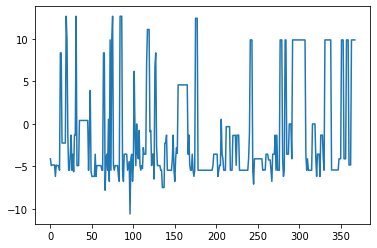

In [86]:
plt.plot(df['chem_pca-c3'])